In [1]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision.transforms.functional import rotate
from torch.utils.data import Dataset, DataLoader

c:\Users\HP\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:

# This code is a PyTorch dataset class that loads the MNIST dataset and applies rotations to the images.
class RotatedMNIST(Dataset):
    def __init__(self, root, train=True, digits=(1, 2)):
        self.mnist = MNIST(root=root, train=train, download=True,
                          transform=ToTensor())  # Convert to tensor upfront
        self.indices = [i for i, (_, label) in enumerate(self.mnist) 
                      if label in digits]
        self.angles = list(range(0, 360, 30))

    def __len__(self):
        return len(self.indices) * len(self.angles)

    def __getitem__(self, idx):
        img_idx = self.indices[idx // len(self.angles)]
        angle = self.angles[idx % len(self.angles)]
        img, label = self.mnist[img_idx]
        
        # Rotate tensor directly (no PIL conversion)
        img_rotated = rotate(img, angle)
        return img_rotated, label, torch.tensor(angle/360.0, dtype=torch.float32)

In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] range automatically
])


train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [13]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


print("Starting VAE Training...")
for epoch in range(20):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset):.4f}')

Starting VAE Training...
Epoch 1, Loss: 154.2721
Epoch 2, Loss: 112.8621
Epoch 3, Loss: 107.0420
Epoch 4, Loss: 104.5923
Epoch 5, Loss: 103.0775
Epoch 6, Loss: 101.9875
Epoch 7, Loss: 101.1702
Epoch 8, Loss: 100.6196
Epoch 9, Loss: 100.1122
Epoch 10, Loss: 99.7227
Epoch 11, Loss: 99.4339
Epoch 12, Loss: 99.0939
Epoch 13, Loss: 98.8460
Epoch 14, Loss: 98.6016
Epoch 15, Loss: 98.3999
Epoch 16, Loss: 98.1911
Epoch 17, Loss: 98.0220
Epoch 18, Loss: 97.8141
Epoch 19, Loss: 97.7028
Epoch 20, Loss: 97.5630


In [19]:
torch.save(model.state_dict(), "vae_mnist.pth")


In [ ]:
model.load_state_dict(torch.load("vae_mnist.pth"))
model.train()  


VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=256, bias=True)
    (6): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=32, bias=True)
  (fc_var): Linear(in_features=256, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3136, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
for epoch in range(21, 31):  
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch}, Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch 21, Loss: 97.4159
Epoch 22, Loss: 97.3002
Epoch 23, Loss: 97.1484
Epoch 24, Loss: 97.0593
Epoch 25, Loss: 96.8989
Epoch 26, Loss: 96.7997
Epoch 27, Loss: 96.7098
Epoch 28, Loss: 96.6413
Epoch 29, Loss: 96.5300
Epoch 30, Loss: 96.4831


In [76]:
# Extract latent representations for training the MLP
latent_vectors = []
angles = []

with torch.no_grad():
    for data, _, angle in train_loader:  # Assuming your dataset returns (image, label, angle)
        data = data.to(device)
        mu, logvar = model.encode(data)
        z = model.reparameterize(mu, logvar)
        
        latent_vectors.append(z.cpu())
        angles.append(angle.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0)
angles = torch.cat(angles, dim=0)

# Define the MLP for learning transformations in latent space
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, latent_dim=32):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Output should be the same size as latent_dim
        )

    def forward(self, x):
        return self.model(x)

mlp = MLP(latent_dim=32).to(device)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Train the MLP
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    for i in range(len(latent_vectors)):
        z = latent_vectors[i].to(device)
        angle = angles[i].to(device)

        mlp_optimizer.zero_grad()
        
        z_rotated = mlp(z)  # Predict transformed latent vector
        loss = criterion(z_rotated, z)  # Compare with original latent vector (self-supervised)
        
        loss.backward()
        mlp_optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(latent_vectors):.4f}")

# Save the trained MLP model
torch.save(mlp.state_dict(), "mlp_symmetry.pth")


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        self.encoder_fc = nn.Linear(12544, 256)  
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256)
        self.decoder_upsample = nn.Linear(256, 12544)  

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)  
        x = self.encoder_fc(x)
        return self.fc_mu(x), self.fc_var(x)

    def decode(self, z):
        x = self.decoder_fc(z)
        x = self.decoder_upsample(x)
        x = x.view(-1, 64, 14, 14)  
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z)
        return recon_x, mu, log_var  

In [ ]:
vae = VAE()
checkpoint = torch.load("vae_mnist.pth", map_location=device)
model_dict = vae.state_dict()

filtered_checkpoint = {k: v for k, v in checkpoint.items() if k in model_dict and v.shape == model_dict[k].shape}

model_dict.update(filtered_checkpoint)
vae.load_state_dict(model_dict)


<All keys matched successfully>

In [ ]:
with torch.no_grad():
    recon_x, _, _ = vae(sample_input)  
print(recon_x.shape)  


torch.Size([1, 1, 28, 28])


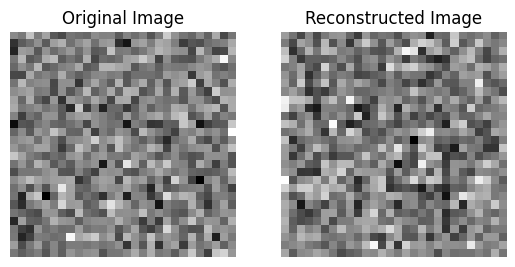

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    recon_x, _, _ = vae(sample_input)

input_img = sample_input.cpu().squeeze().numpy()
recon_img = recon_x.cpu().squeeze().numpy()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(input_img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(recon_img, cmap='gray')
ax[1].set_title("Reconstructed Image")
ax[1].axis("off")

plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def get_latent_vectors(vae, dataloader, device="cuda"):
    vae.eval()
    latent_vectors = []
    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            mean, logvar = vae.encoder(imgs)
            z = vae.reparameterize(mean, logvar)
            latent_vectors.append(z.cpu().numpy())
    return np.concatenate(latent_vectors, axis=0)

def visualize_pca(latent_vectors):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(latent_vectors)
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.5)
    plt.title("PCA of Latent Space")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

def cluster_latent_space(latent_vectors, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(latent_vectors)
    return labels

# Usage:
# latent_vectors = get_latent_vectors(trained_vae, test_dataloader)
# visualize_pca(latent_vectors)
# labels = cluster_latent_space(latent_vectors)
# print("Cluster Labels:", labels)


In [ ]:
checkpoint = torch.load("vae_mnist.pth")
print(checkpoint.keys())  


odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.5.weight', 'encoder.5.bias', 'fc_mu.weight', 'fc_mu.bias', 'fc_var.weight', 'fc_var.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.5.weight', 'decoder.5.bias', 'decoder.7.weight', 'decoder.7.bias'])


In [67]:
print(vae)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (encoder_fc): Linear(in_features=12544, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=32, bias=True)
  (fc_var): Linear(in_features=256, out_features=32, bias=True)
  (decoder_fc): Linear(in_features=32, out_features=256, bias=True)
  (decoder_upsample): Linear(in_features=256, out_features=12544, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Sigmoid()
  )
)


In [ ]:
import torch

old_state_dict = torch.load("vae_mnist.pth")

new_state_dict = {}

for key in old_state_dict.keys():
    new_key = key  

    if "encoder.5" in key:  # Fix missing layer issue
        new_key = key.replace("encoder.5", "encoder.3")  

    # Fix decoder layer names
    if "decoder.5" in key:
        new_key = key.replace("decoder.5", "decoder.3")
    if "decoder.7" in key:
        new_key = key.replace("decoder.7", "decoder.4")  # Adjust numbering

    # Fix decoder_fc and decoder_upsample (remove if necessary)
    if "decoder_fc" in key or "decoder_upsample" in key:
        continue  # Skip these keys, as they don't exist in the saved model

    # Add the fixed key-value pair to the new dictionary
    new_state_dict[new_key] = old_state_dict[key]

# Save the corrected state dictionary
torch.save(new_state_dict, "vae_mnist_fixed.pth")

print("✅ Fixed model saved as 'vae_mnist_fixed.pth'. Now, load this into your VAE class.")


✅ Fixed model saved as 'vae_mnist_fixed.pth'. Now, load this into your VAE class.


In [69]:
trained_vae = VAE(latent_dim=32)  # Ensure latent_dim matches
trained_vae.load_state_dict(torch.load("vae_mnist_fixed.pth"), strict=True)  # strict=True should now work
trained_vae.to("cuda")  # Move to GPU if available
trained_vae.eval()  # Set to evaluation mode


RuntimeError: Error(s) in loading state_dict for VAE:
	Missing key(s) in state_dict: "encoder_fc.weight", "encoder_fc.bias", "decoder_fc.weight", "decoder_fc.bias", "decoder_upsample.weight", "decoder_upsample.bias". 
	Unexpected key(s) in state_dict: "encoder.3.weight", "encoder.3.bias", "decoder.4.weight", "decoder.4.bias", "decoder.3.weight", "decoder.3.bias". 
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([256, 32]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([3136, 256]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([3136]) from checkpoint, the shape in current model is torch.Size([1]).

In [72]:
import torch
print("CUDA Available:", torch.cuda.is_available())


CUDA Available: False


In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Assuming we have a trained VAE encoder
# Function to extract latent representations
def get_latent_vectors(vae, dataloader, device="cuda"):
    vae.eval()
    latent_vectors = []
    rotated_latent_vectors = []
    labels_list = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            mean, logvar = vae.encoder(imgs)
            z = vae.reparameterize(mean, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels_list.append(labels.numpy())

            # Rotate images by 30 degrees and get new latent vectors
            rotated_imgs = torch.rot90(imgs, k=1, dims=[2, 3])  # 90-degree rotation as an example
            mean_r, logvar_r = vae.encoder(rotated_imgs)
            z_rotated = vae.reparameterize(mean_r, logvar_r)
            rotated_latent_vectors.append(z_rotated.cpu().numpy())
    
    return np.concatenate(latent_vectors, axis=0), np.concatenate(rotated_latent_vectors, axis=0), np.concatenate(labels_list, axis=0)

# Perform PCA to visualize the latent space
def visualize_pca(latent_vectors, labels, title="PCA of Latent Space"):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(latent_vectors)
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar()
    plt.show()

# Perform clustering to find symmetry patterns
def cluster_latent_space(latent_vectors, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(latent_vectors)
    return labels, kmeans.cluster_centers_

# Validate discovered symmetries by comparing rotated cluster assignments
def validate_symmetry(original_centers, rotated_centers):
    distances = cdist(original_centers, rotated_centers, metric='euclidean')
    mean_distance = np.mean(np.min(distances, axis=1))
    print(f"Mean distance between original and rotated clusters: {mean_distance}")
    return mean_distance

# Steps to execute:
# 1. Extract latent vectors for original and rotated images
latent_vectors, rotated_latent_vectors, img_labels = get_latent_vectors(trained_vae, test_dataloader)

# 2. Visualize latent space
visualize_pca(latent_vectors, img_labels, title="Original Latent Space")
visualize_pca(rotated_latent_vectors, img_labels, title="Rotated Latent Space")

# 3. Perform clustering
cluster_labels, cluster_centers = cluster_latent_space(latent_vectors)
rotated_cluster_labels, rotated_cluster_centers = cluster_latent_space(rotated_latent_vectors)

# 4. Validate symmetry
mean_dist = validate_symmetry(cluster_centers, rotated_cluster_centers)

NameError: name 'trained_vae' is not defined

bekar